In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bert-model/bert_pretrained.pt
/kaggle/input/bert-model/bert-it-vocab.txt


In [2]:
!pip install transformers datasets torch tqdm sklearn
import os
import math
import torch
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py) ...   error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [3]:
# Create a symbolic link to make the file accessible in /kaggle/working
!ln -sf /kaggle/input/bert-model/bert_pretrained.pt /kaggle/working/bert_pretrained.pt
!ln -sf /kaggle/input/bert-model/bert-it-vocab.txt /kaggle/working/bert-it-vocab.txt

# Verify the file is accessible
!ls -la /kaggle/working/bert_pretrained.pt


lrwxrwxrwx 1 root root 43 Mar 29 13:18 /kaggle/working/bert_pretrained.pt -> /kaggle/input/bert-model/bert_pretrained.pt


In [4]:
class PositionalEmbedding(torch.nn.Module):
    def __init__(self, d_model, max_len=128):
        super().__init__()
        pe = torch.zeros(max_len, d_model).float()
        pe.require_grad = False
        for pos in range(max_len): 
            for i in range(0, d_model, 2): 
                pe[pos, i] = math.sin(pos / (10000 ** ((2 * i)/d_model)))
                pe[pos, i + 1] = math.cos(pos / (10000 ** ((2 * (i + 1))/d_model)))
        self.pe = pe.unsqueeze(0)
        
    def forward(self, x):
        return self.pe[:, :x.size(1), :].to(x.device)

class BERTEmbedding(torch.nn.Module):
    def __init__(self, vocab_size, embed_size, seq_len=64, dropout=0.1):
        super().__init__()
        self.embed_size = embed_size
        self.token = torch.nn.Embedding(vocab_size, embed_size, padding_idx=0)
        self.segment = torch.nn.Embedding(3, embed_size, padding_idx=0)
        self.position = PositionalEmbedding(d_model=embed_size, max_len=seq_len)
        self.dropout = torch.nn.Dropout(p=dropout)
        
    def forward(self, sequence, segment_label):
        x = self.token(sequence) + self.position(sequence) + self.segment(segment_label)
        return self.dropout(x)

class MultiHeadedAttention(torch.nn.Module):
    def __init__(self, heads, d_model, dropout=0.1):
        super(MultiHeadedAttention, self).__init__()
        assert d_model % heads == 0
        self.d_k = d_model // heads
        self.heads = heads
        self.dropout = torch.nn.Dropout(dropout)
        self.query = torch.nn.Linear(d_model, d_model)
        self.key = torch.nn.Linear(d_model, d_model)
        self.value = torch.nn.Linear(d_model, d_model)
        self.output_linear = torch.nn.Linear(d_model, d_model)
        
    def forward(self, query, key, value, mask):
        query = self.query(query)
        key = self.key(key) 
        value = self.value(value) 
        query = query.view(query.shape[0], -1, self.heads, self.d_k).permute(0, 2, 1, 3) 
        key = key.view(key.shape[0], -1, self.heads, self.d_k).permute(0, 2, 1, 3) 
        value = value.view(value.shape[0], -1, self.heads, self.d_k).permute(0, 2, 1, 3) 
        scores = torch.matmul(query, key.permute(0, 1, 3, 2)) / math.sqrt(query.size(-1))
        scores = scores.masked_fill(mask == 0, -1e9) 
        weights = torch.nn.functional.softmax(scores, dim=-1) 
        weights = self.dropout(weights)
        context = torch.matmul(weights, value)
        context = context.permute(0, 2, 1, 3).contiguous().view(context.shape[0], -1, self.heads * self.d_k)
        return self.output_linear(context)

class FeedForward(torch.nn.Module):
    def __init__(self, d_model, middle_dim=2048, dropout=0.1):
        super(FeedForward, self).__init__()
        self.fc1 = torch.nn.Linear(d_model, middle_dim)
        self.fc2 = torch.nn.Linear(middle_dim, d_model)
        self.dropout = torch.nn.Dropout(dropout)
        self.activation = torch.nn.GELU()

    def forward(self, x):
        out = self.activation(self.fc1(x))
        out = self.fc2(self.dropout(out))
        return out

class EncoderLayer(torch.nn.Module):
    def __init__(self, d_model=768, heads=12, feed_forward_hidden=768 * 4, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.layernorm = torch.nn.LayerNorm(d_model)
        self.self_multihead = MultiHeadedAttention(heads, d_model)
        self.feed_forward = FeedForward(d_model, middle_dim=feed_forward_hidden)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, embeddings, mask):
        interacted = self.dropout(self.self_multihead(embeddings, embeddings, embeddings, mask))
        interacted = self.layernorm(interacted + embeddings)
        feed_forward_out = self.dropout(self.feed_forward(interacted))
        encoded = self.layernorm(feed_forward_out + interacted)
        return encoded

class BERT(torch.nn.Module):
    def __init__(self, vocab_size, d_model=768, n_layers=12, heads=12, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.n_layers = n_layers
        self.heads = heads
        self.feed_forward_hidden = d_model * 4
        self.embedding = BERTEmbedding(vocab_size=vocab_size, embed_size=d_model)
        self.encoder_blocks = torch.nn.ModuleList(
            [EncoderLayer(d_model, heads, d_model * 4, dropout) for _ in range(n_layers)])

    def forward(self, x, segment_info):
        mask = (x > 0).unsqueeze(1).repeat(1, x.size(1), 1).unsqueeze(1)
        x = self.embedding(x, segment_info)
        for encoder in self.encoder_blocks:
            x = encoder.forward(x, mask)
        return x

In [5]:
#sentiment classifier that will use our pre-trained BERT
class BERTSentimentClassifier(torch.nn.Module):
    def __init__(self, bert_model, num_classes=2):
        super(BERTSentimentClassifier, self).__init__()
        self.bert = bert_model
        self.dropout = torch.nn.Dropout(0.1)
        self.classifier = torch.nn.Linear(768, num_classes)
        
    def forward(self, input_ids, segment_info=None):
        # Get BERT outputs
        outputs = self.bert(input_ids, segment_info)
        
        # Use the [CLS] token representation for classification
        pooled_output = outputs[:, 0, :]
        
        # Apply dropout and the classifier
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        
        return logits


In [6]:
#dataset class for the IMDB dataset
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=64):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        # Tokenize the text
        encoding = self.tokenizer(text, add_special_tokens=True, 
                                 max_length=self.max_len, 
                                 padding='max_length',
                                 truncation=True,
                                 return_tensors='pt')
        
        # Create segment info (all 1s for single sentence)
        segment_info = torch.ones_like(encoding['input_ids'])
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'segment_info': segment_info.flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [7]:
#Loading and Preparing the IMDB Dataset
def load_and_prepare_imdb_data(tokenizer, max_len=64, batch_size=16):
    # Load IMDB dataset
    from datasets import load_dataset
    dataset = load_dataset("imdb")
    
    # Convert to pandas DataFrames
    train_df = pd.DataFrame({
        'text': dataset['train']['text'],
        'label': dataset['train']['label']
    })
    
    test_df = pd.DataFrame({
        'text': dataset['test']['text'],
        'label': dataset['test']['label']
    })
    
    # Split training data for validation
    train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)
    
    # Create datasets
    train_dataset = SentimentDataset(train_df['text'].values, train_df['label'].values, tokenizer, max_len)
    val_dataset = SentimentDataset(val_df['text'].values, val_df['label'].values, tokenizer, max_len)
    test_dataset = SentimentDataset(test_df['text'].values, test_df['label'].values, tokenizer, max_len)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    return train_loader, val_loader, test_loader

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

#Fine-tuning Function
def fine_tune_bert_for_sentiment(pretrained_bert_path, tokenizer_path, max_len=64, batch_size=16, epochs=4, learning_rate=2e-5):
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Load tokenizer
    tokenizer = BertTokenizer.from_pretrained(tokenizer_path, local_files_only=True)
    
    # Load pre-trained BERT model
    bert_model = BERT(vocab_size=len(tokenizer.vocab))
    
    # Load the pre-trained weights
    checkpoint = torch.load(pretrained_bert_path, map_location=device)
    
    # Load the state dict
    try:
        bert_model.load_state_dict(checkpoint['model_state_dict']['bert'])
        print("Loaded BERT from model_state_dict['bert']")
    except:
        try:
            bert_model.load_state_dict(checkpoint['model_state_dict'])
            print("Loaded BERT from model_state_dict")
        except:
            print("Could not load BERT model directly, trying to extract state dict...")
            # Try to extract the BERT part from the state dict
            bert_state_dict = {}
            for key, value in checkpoint['model_state_dict'].items():
                if key.startswith('bert.'):
                    bert_state_dict[key[5:]] = value
            
            if bert_state_dict:
                bert_model.load_state_dict(bert_state_dict)
                print("Loaded BERT from extracted state dict")
            else:
                print("Failed to load pre-trained BERT model")
    
    # Create sentiment classifier
    model = BERTSentimentClassifier(bert_model)
    model.to(device)
    
    # Load and prepare data
    train_loader, val_loader, test_loader = load_and_prepare_imdb_data(tokenizer, max_len, batch_size)
    
    # Set up the optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
    loss_fn = torch.nn.CrossEntropyLoss()
    
    # Set up learning rate scheduler
    total_steps = len(train_loader) * epochs
    scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, 
                                                 start_factor=1.0,
                                                 end_factor=0.1,
                                                 total_iters=total_steps)
    
    # Training loop
    best_accuracy = 0
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        
        for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
            input_ids = batch['input_ids'].to(device)
            segment_info = batch['segment_info'].to(device)
            labels = batch['labels'].to(device)
            
            # Forward pass
            outputs = model(input_ids, segment_info)
            loss = loss_fn(outputs, labels)
            
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
            
            train_loss += loss.item()
        
        # Validation
        model.eval()
        val_accuracy = 0
        val_loss = 0
        
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}"):
                input_ids = batch['input_ids'].to(device)
                segment_info = batch['segment_info'].to(device)
                labels = batch['labels'].to(device)
                
                outputs = model(input_ids, segment_info)
                loss = loss_fn(outputs, labels)
                
                val_loss += loss.item()
                
                preds = torch.argmax(outputs, dim=1)
                val_accuracy += (preds == labels).sum().item()
        
        val_accuracy /= len(val_loader.dataset)
        
        print(f"Epoch {epoch+1}:")
        print(f"Train Loss: {train_loss/len(train_loader):.4f}")
        print(f"Val Loss: {val_loss/len(val_loader):.4f}")
        print(f"Val Accuracy: {val_accuracy:.4f}")
        
        # Save the best model
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_accuracy': val_accuracy
            }, 'bert_sentiment_classifier.pt')
            print(f"Model saved with accuracy: {val_accuracy:.4f}")
    
    # Test the model
    model.eval()
    test_accuracy = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):
            input_ids = batch['input_ids'].to(device)
            segment_info = batch['segment_info'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, segment_info)
            preds = torch.argmax(outputs, dim=1)
            test_accuracy += (preds == labels).sum().item()
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    test_accuracy /= len(test_loader.dataset)
    print(f"Test Accuracy: {test_accuracy:.4f}")

    cm = confusion_matrix(all_labels, all_preds)

    # Create the ConfusionMatrixDisplay object
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])

    # Plot the confusion matrix
    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(ax=ax, cmap='Blues', values_format='d')

    # Customize the plot
    plt.title('Confusion Matrix for BERT Sentiment Analysis')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')

    # Show the plot
    plt.tight_layout()
    plt.show()
    
    # Calculate and print classification report
    from sklearn.metrics import classification_report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=['Negative', 'Positive']))
    
    return model


In [9]:
#Prediction Function
def predict_sentiment(text, model, tokenizer, max_len=64):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()
    
    # Tokenize the input text
    encoding = tokenizer(text, add_special_tokens=True, 
                         max_length=max_len, 
                         padding='max_length',
                         truncation=True,
                         return_tensors='pt')
    
    input_ids = encoding['input_ids'].to(device)
    segment_info = torch.ones_like(input_ids).to(device)
    
    with torch.no_grad():
        outputs = model(input_ids, segment_info)
        preds = torch.softmax(outputs, dim=1)
        
    sentiment_score = preds[:, 1].item()  # Probability of positive sentiment
    sentiment = "Positive" if sentiment_score > 0.5 else "Negative"
    
    return {
        'sentiment': sentiment,
        'score': sentiment_score
    }

Using device: cuda


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1925: FutureWarning: Calling BertTokenizer.from_pretrained() with the path to a single file or url is deprecated and won't be possible anymore in v5. Use a model identifier or the path to a directory instead.
  warnings.warn(
<ipython-input-8-59396e61d5b8>:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_glob

Could not load BERT model directly, trying to extract state dict...
Loaded BERT from extracted state dict


Validation Epoch 1: 100%|██████████| 157/157 [00:18<00:00,  8.69it/s]


Epoch 1:
Train Loss: 0.6988
Val Loss: 0.7556
Val Accuracy: 0.5192
Model saved with accuracy: 0.5192


Validation Epoch 2: 100%|██████████| 157/157 [00:18<00:00,  8.68it/s]


Epoch 2:
Train Loss: 0.6507
Val Loss: 0.5936
Val Accuracy: 0.6780
Model saved with accuracy: 0.6780


Validation Epoch 3: 100%|██████████| 157/157 [00:18<00:00,  8.59it/s]


Epoch 3:
Train Loss: 0.5674
Val Loss: 0.5527
Val Accuracy: 0.7108
Model saved with accuracy: 0.7108


Validation Epoch 4: 100%|██████████| 157/157 [00:18<00:00,  8.67it/s]


Epoch 4:
Train Loss: 0.5095
Val Loss: 0.5332
Val Accuracy: 0.7356
Model saved with accuracy: 0.7356


Testing: 100%|██████████| 1563/1563 [03:00<00:00,  8.64it/s]


Test Accuracy: 0.7317


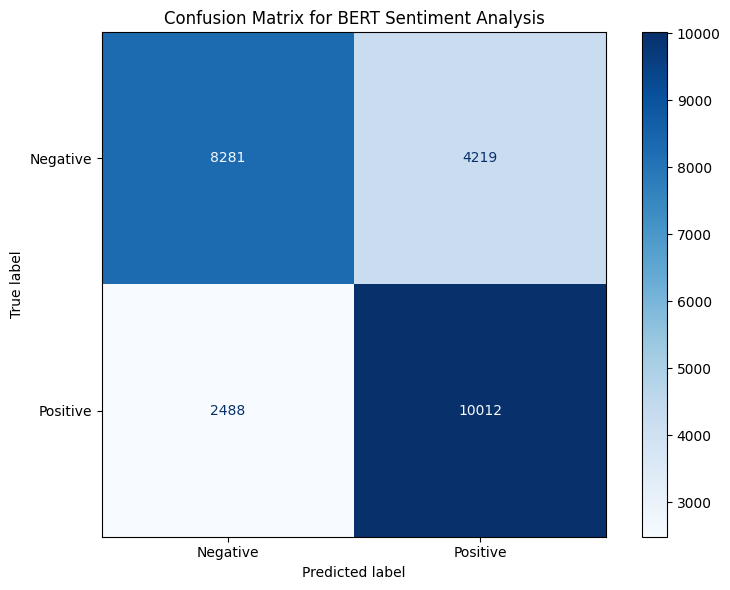


Classification Report:
              precision    recall  f1-score   support

    Negative       0.77      0.66      0.71     12500
    Positive       0.70      0.80      0.75     12500

    accuracy                           0.73     25000
   macro avg       0.74      0.73      0.73     25000
weighted avg       0.74      0.73      0.73     25000



In [10]:
# Main execution
if __name__ == "__main__":
    # Set random seeds for reproducibility
    random.seed(42)
    np.random.seed(42)
    torch.manual_seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(42)
    
    # Fine-tune the model
    sentiment_model = fine_tune_bert_for_sentiment(
        "/kaggle/working/bert_pretrained.pt",
    "/kaggle/working/bert-it-vocab.txt")


In [12]:
# Example usage
tokenizer = BertTokenizer.from_pretrained("/kaggle/working/bert-it-vocab.txt", local_files_only=True)

sample_text = "This movie was absolutely fantastic! The acting was superb."
result = predict_sentiment(sample_text, sentiment_model, tokenizer)
print(f"Sentiment: {result['sentiment']}")
print(f"Score: {result['score']:.4f}")

Sentiment: Positive
Score: 0.9525


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1925: FutureWarning: Calling BertTokenizer.from_pretrained() with the path to a single file or url is deprecated and won't be possible anymore in v5. Use a model identifier or the path to a directory instead.
  warnings.warn(
